# This is the first step in our analysis of a real-life dataset.

We are going to re-analyse the dataset presented in the paper "Single-cell transcriptomics identifies an effectorness gradient shaping the response of CD4+ T cells to cytokines" by Cano-Gamez et al. (https://www.nature.com/articles/s41467-020-15543-y). In summary, they have studied the response of CD4+ T cells in response to different cytokines forming an effectorness gradient. In this lab we will analyze bulk RNA-seq data to elucidate the expression patterns of naive CD4+ T cells showing the Th2 phenotype as compared to the Th0 phenotype.

In [15]:
# load required packages
require(ggplot2, quietly = TRUE)
require(DESeq2, quietly = TRUE)
require(EnhancedVolcano, quietly = TRUE)
require(testthat, quietly = TRUE)

In [17]:
# loading phenotype ananotation data located in the following file:
# ./data/NCOMMS-19-7936188_bulk_RNAseq_raw_counts.txt.gz

ge_matrix <- read.table("./data/NCOMMS-19-7936188_bulk_RNAseq_raw_counts.txt.gz", 
                         header = TRUE, 
                         sep = "\t", 
                         quote = "", 
                         stringsAsFactors = FALSE)

# your code here


dim(ge_matrix)


[1] 58051    94

In [49]:
# loading phenotype annotation data located in the following file:
# ./data/NCOMMS-19-7936188_bulk_RNAseq_metadata.txt.gz

pheno_matrix <- read.table("./data/NCOMMS-19-7936188_bulk_RNAseq_metadata.txt.gz", 
                            header = TRUE, 
                            sep = "\t", 
                            quote = "", 
                            stringsAsFactors = FALSE,
                            )

# Assign the column "sample_id" as rownames of the pheno_matrix data.frame
rownames(pheno_matrix) <- pheno_matrix$sample_id

# your code here


dim(pheno_matrix)
head(pheno_matrix)


[1] 94 10

,sample_id,cell_type,cytokine_condition,stimulation_time,donor_id,sex,age,sequencing_batch,cell_culture_batch,rna_integrity_number
,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<int>,<int>,<dbl>
I0712,I0712,CD4_Naive,IFNB,16h,257,Male,38,1,3,9.5
I0713,I0713,CD4_Naive,Th17,16h,254,Male,58,1,3,9.3
I0717,I0717,CD4_Memory,Resting,5d,265,Male,59,1,4,9.7
I0721,I0721,CD4_Naive,Th2,5d,257,Male,38,1,3,10.0
I0726,I0726,CD4_Memory,Th17,5d,264,Male,27,1,4,9.9
I0731,I0731,CD4_Naive,Th0,16h,257,Male,38,1,3,9.4


## We start by performing a DEG analysis for naive CD4+ cells

In [20]:
# Create an index "toSelect", selecting samples (rows) from the phenotype matrix "pheno_matrix" where column
# "stimulation_time" equals "5d", the cell phenotype ("cytokine_condition") equals either 'Th2' or'Th0', and 
# the sample cell type "cell_type" is "CD4_Naive"
toSelect <- which(
  pheno_matrix$stimulation_time == "5d" & 
  pheno_matrix$cytokine_condition %in% c("Th2", "Th0") & 
  pheno_matrix$cell_type == "CD4_Naive"
)


# your code here

# We use this index now to subset our samples before doing the differential 
# expression analysis.
pheno_matrix_subset <- pheno_matrix[toSelect, ]
ge_matrix_subset <- ge_matrix[ , toSelect]

dim(pheno_matrix_subset)
dim(ge_matrix_subset)

[1]  9 10

[1] 58051     9

In [21]:
# Now we have to generate the DESeq2 dataset using the phenotype matrix subset (ge_matrix_subset) 
# and count matrix subset (pheno_matrix_subset) that we have created above. Furthermore, we need to
# set the design formula to measure the effect of the variable "cytokine_condition".
# Remember that we have selected the samples to have either cytokine_condition, i.e. phenotype
# Th0 or Th2, by setting the design to column cytokine_condition we set our DESeq up to measure 
# the differtially expressed genes (DEGs) between these two phenotypes.

dds <- DESeqDataSetFromMatrix(
  countData = ge_matrix_subset,
  colData = pheno_matrix_subset,
  design = ~ cytokine_condition
)

# your code here


# apply minimal filtering, keeping only genes (rows) with at least 10 counts between all retained samples
keep <- rowSums(counts(dds)) >= 10
dds <- dds[keep,]
dds

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


class: DESeqDataSet 
dim: 27516 9 
metadata(1): version
assays(1): counts
rownames(27516): ENSG00000227232 ENSG00000278267 ... ENSG00000271254
  ENSG00000275405
rowData names(0):
colnames(9): I0721 I0732 ... I0872 I0877
colData names(10): sample_id cell_type ... cell_culture_batch
  rna_integrity_number

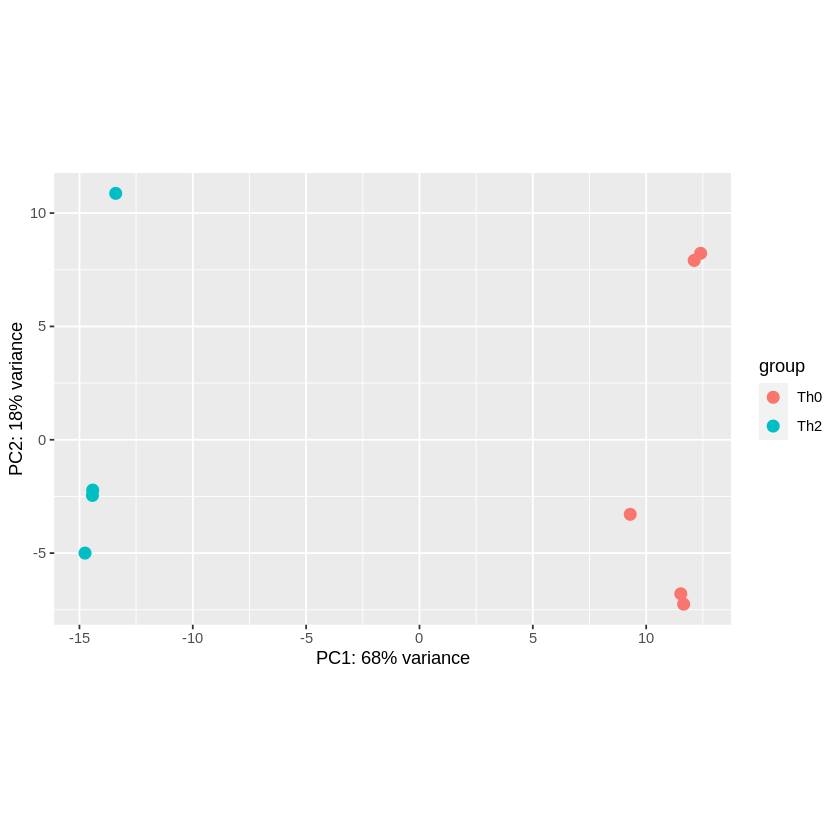

In [22]:
# This DESeq2 dataset can now be used to plot a principle component analysis,
# e.g. to inspect whether the samples separate according to the applied treatment.
plotPCA(rlog(dds), intgroup = 'cytokine_condition')

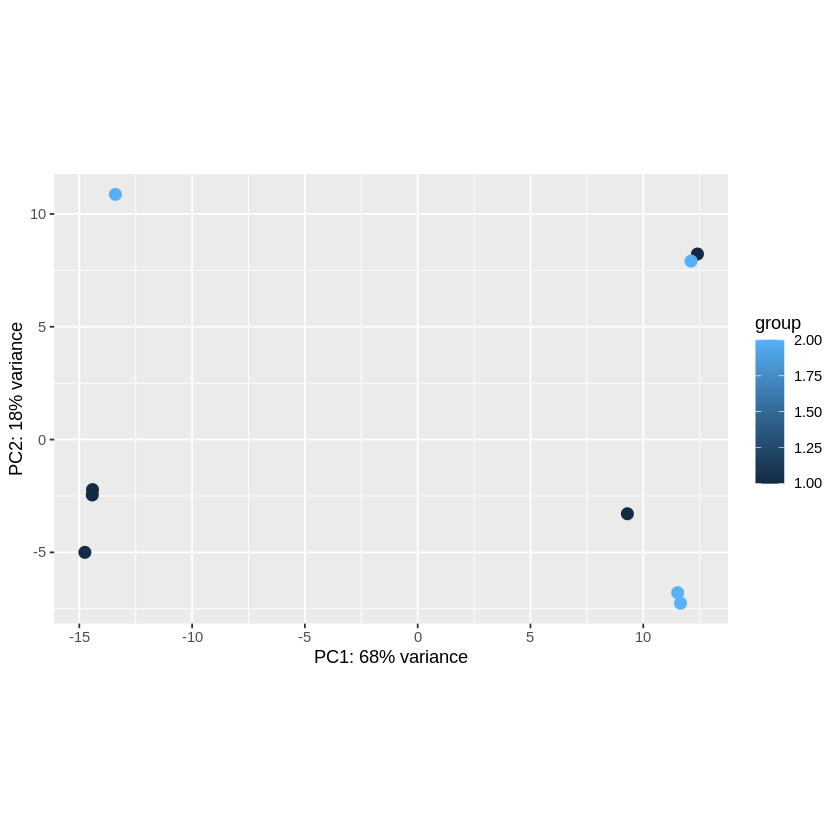

In [23]:
# However, we dont want to see a separation of samples by by sequencing batch as this would
# constitute a confounding factor. Let's check that

plotPCA(rlog(dds), intgroup = 'sequencing_batch')

In [24]:
# Now we can run the differential expression analysis with the DESeq command
dds <- DESeq(object = dds)
# The result of the analysis is then accessible via the "results" command:
DESeqRes <- results(dds)

# We can also discard genes with adjusted P-values of NA, which DESeq2 assignes when certain quality control
# criteria are not met, such as low counts
DESeqRes <- DESeqRes[!is.na(DESeqRes$padj),]

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [25]:
# Now you can inspect the result object. Order the results table by adjusted p-value (column "padj") in
# ascending order, use the function "order"

DESeqResSorted <- DESeqRes[order(DESeqRes$padj),]

# your code here


# Inspect the top genes
head(DESeqResSorted)

log2 fold change (MLE): cytokine condition Th2 vs Th0 
Wald test p-value: cytokine condition Th2 vs Th0 
DataFrame with 6 rows and 6 columns
                        baseMean    log2FoldChange              lfcSE
                       <numeric>         <numeric>          <numeric>
ENSG00000189221 1692.64307218668  7.57998568070103  0.266534927907165
ENSG00000050405 11267.3060671304  2.83111088164711 0.0999389764174932
ENSG00000204177 286.369283171735  4.51111090333947  0.184418070081082
ENSG00000125901 2953.85686373281  2.45282051458582  0.105129761514081
ENSG00000033327 2579.11095222412  1.45913529084305 0.0644535212334884
ENSG00000225783 5977.30272895174 -1.85365901721805 0.0865863801153483
                             stat                pvalue                  padj
                        <numeric>             <numeric>             <numeric>
ENSG00000189221  28.4389957452074  6.6666785849836e-178  1.4430025797197e-173
ENSG00000050405  28.3283958184663 1.54507623528388e-176 1.6721587

In [26]:
# Now we can filter out the statistically significant differentially expressed genes.
# Apply two criteria to create an index, column padj <= 0.01 and the 
# absolute value of column log2FoldChange > 1, hint: use the function abs

idx <- which(DESeqResSorted$padj <= 0.01 & abs(DESeqResSorted$log2FoldChange) > 1)

# your code here


cat("number of significant DEGs:" , length(idx), "\n")

# And our 10 genes with the stronges response are:
DESeqResSorted[head(idx, 10),]

number of significant DEGs: 939 


log2 fold change (MLE): cytokine condition Th2 vs Th0 
Wald test p-value: cytokine condition Th2 vs Th0 
DataFrame with 10 rows and 6 columns
                        baseMean    log2FoldChange              lfcSE
                       <numeric>         <numeric>          <numeric>
ENSG00000189221 1692.64307218668  7.57998568070103  0.266534927907165
ENSG00000050405 11267.3060671304  2.83111088164711 0.0999389764174932
ENSG00000204177 286.369283171735  4.51111090333947  0.184418070081082
ENSG00000125901 2953.85686373281  2.45282051458582  0.105129761514081
ENSG00000033327 2579.11095222412  1.45913529084305 0.0644535212334884
ENSG00000225783 5977.30272895174 -1.85365901721805 0.0865863801153483
ENSG00000154096 468.212096629712  8.22451262562469  0.390177224027555
ENSG00000131016 1894.13557012306    3.547024192544  0.169828853168658
ENSG00000197594  310.18407396876  7.46495658643132  0.369328300836003
ENSG00000152990  1201.4968147833  2.22187765652959   0.11364098843249
                  

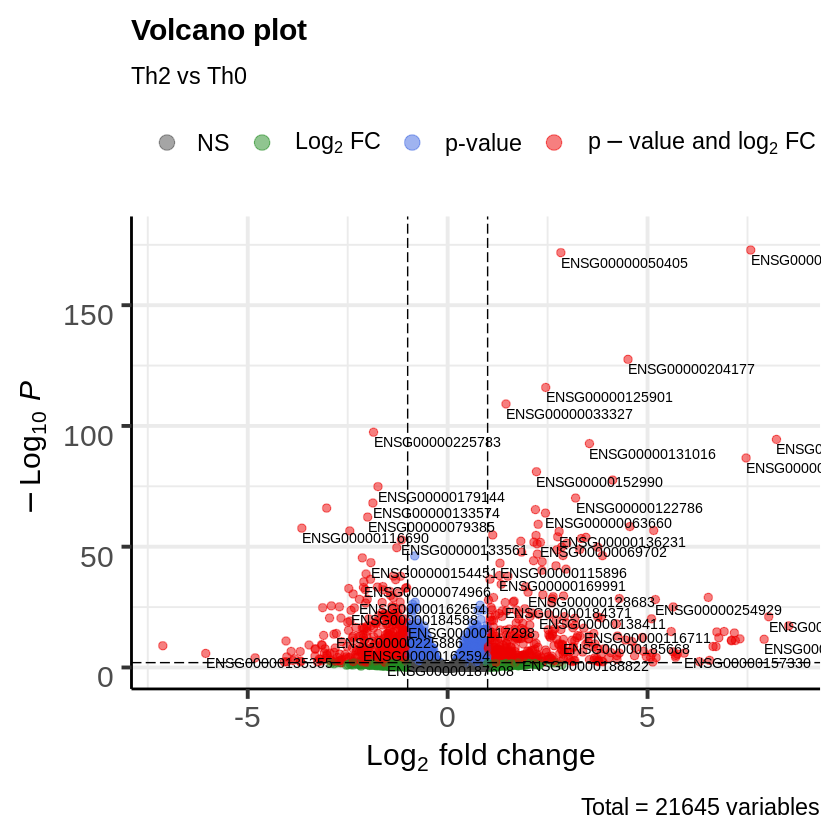

In [27]:
# Finally, a volcano plot is a good way of visualizing the result of the differential expression analysis,
# including the log-fold-change and P-value of the considered genes.

EnhancedVolcano(DESeqRes, 
                lab = rownames(DESeqRes), 
                x = 'log2FoldChange', y = 'padj', 
                subtitle = 'Th2 vs Th0', 
                labSize = 3, 
                pCutoff = 0.01,
                FCcutoff = 1,
                drawConnectors = FALSE)

## Now we repeat the DEG analysis for memory cells

In [28]:
# Again, we have to create an index "toSelect", selecting samples (rows) from the phenotype 
# matrix "pheno_matrix" where column "stimulation_time" equals "5d", the cell phenotype 
# ("cytokine_condition") equals either 'Th2' or'Th0', and the sample cell type "cell_type" is "CD4_Memory"

toSelect <- which(pheno_matrix$stimulation_time == "5d" & 
                  pheno_matrix$cytokine_condition %in% c('Th2', 'Th0') & 
                  pheno_matrix$cell_type == "CD4_Memory")

# your code here


# We use this index now to subset our samples before doing the differential 
# expression analysis.
pheno_matrix_subset <- pheno_matrix[toSelect, ]
ge_matrix_subset <- ge_matrix[ , toSelect]

dim(pheno_matrix_subset)
dim(ge_matrix_subset)

[1]  9 10

[1] 58051     9

In [29]:
# Generate the DESeq2 dataset using the phenotype matrix subset and count matrix subset. The 
# design formula to is still "cytokine_condition".

ddsMem <- DESeqDataSetFromMatrix(countData = ge_matrix_subset,
                                  colData = pheno_matrix_subset,
                                  design = ~ cytokine_condition)

# your code here


# apply minimal filtering, keeping only genes (rows) with at least 10 counts between all retained samples
keep <- rowSums(counts(ddsMem)) >= 10
ddsMem <- ddsMem[keep,]
ddsMem

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”


class: DESeqDataSet 
dim: 26656 9 
metadata(1): version
assays(1): counts
rownames(26656): ENSG00000227232 ENSG00000278267 ... ENSG00000271254
  ENSG00000275405
rowData names(0):
colnames(9): I0736 I0749 ... I0867 I0874
colData names(10): sample_id cell_type ... cell_culture_batch
  rna_integrity_number

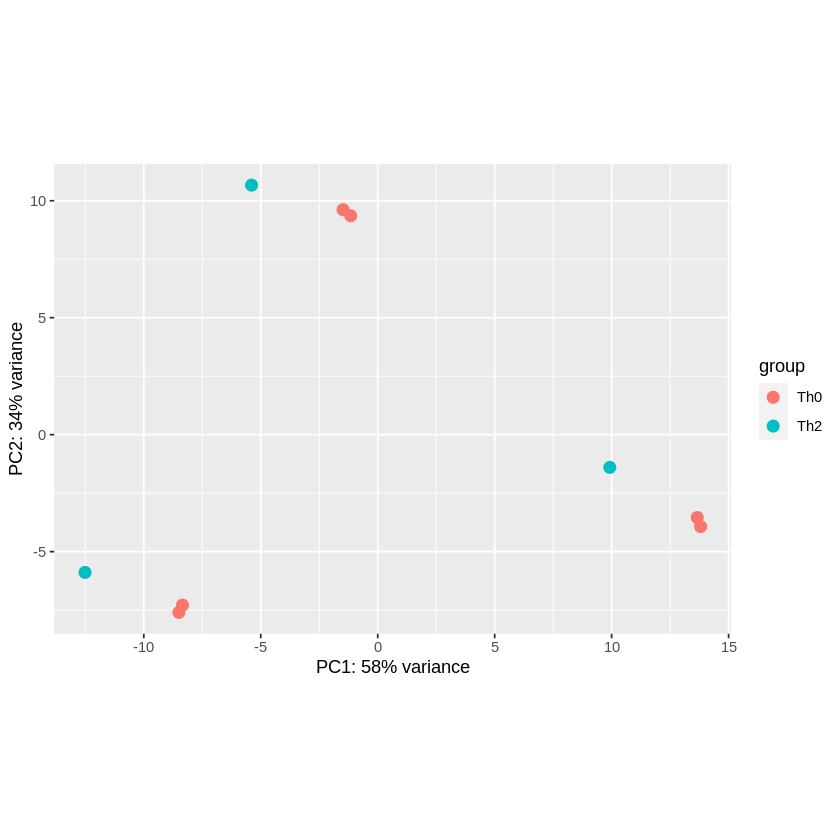

In [30]:
# This DESeq2 dataset can now be used to plot a principle component analysis,
# e.g. to inspect whether the samples separate according to the applied treatment.

plotPCA(rlog(ddsMem), intgroup = 'cytokine_condition')

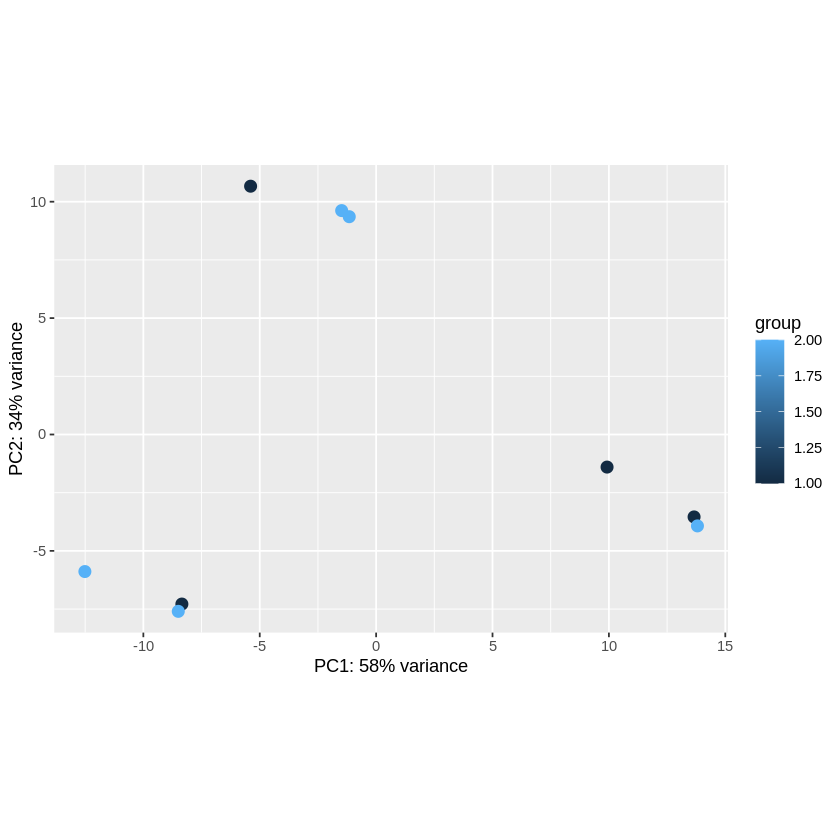

In [31]:
# However, we dont want to see a separation of samples by by sequencing batch as this would
# constitute a confounding factor. Let's check that

plotPCA(rlog(ddsMem), intgroup = 'sequencing_batch')

In [32]:
# Now we can run the differential expression analysis with the DESeq command
ddsMem <- DESeq(object = ddsMem)
# The result of the analysis is then accessible via the "results" command:
DESeqMemRes <- results(ddsMem)

# We can also discard genes with adjusted P-values of NA, which DESeq2 assignes when certain quality control
# criteria are not met, such as low counts
DESeqMemRes <- DESeqMemRes[!is.na(DESeqMemRes$padj),]

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



In [33]:
# Now you can inspect the result object. Order the results table by adjusted p-value (column "padj") in
# ascending order, use the function "order"

DESeqMemResSorted <- DESeqMemRes[order(DESeqMemRes$padj), ]

# your code here


# Inspect the top genes
head(DESeqMemResSorted)

log2 fold change (MLE): cytokine condition Th2 vs Th0 
Wald test p-value: cytokine condition Th2 vs Th0 
DataFrame with 6 rows and 6 columns
                        baseMean     log2FoldChange              lfcSE
                       <numeric>          <numeric>          <numeric>
ENSG00000145839 1501.35903253062  0.980118845489905 0.0940843726535917
ENSG00000102970 202.855469985311   1.56694940179679  0.176911307986771
ENSG00000049249 2356.48879590186  0.484300839985658 0.0661352937482808
ENSG00000166949 2947.20477967503 -0.754552787697488  0.112801757908666
ENSG00000023171 3275.60681781047 -0.523241831319512 0.0790959717330436
ENSG00000159216 6041.29248909045  0.420910480789458 0.0651092620075711
                             stat               pvalue                 padj
                        <numeric>            <numeric>            <numeric>
ENSG00000145839  10.4174457228789 2.06422528710071e-25 4.96900311110882e-21
ENSG00000102970   8.8572597174736 8.20053239753115e-19 9.870160

In [34]:
# Now we can filter out the statistically significant differentially expressed genes.
# Apply two criteria to create an index, column padj <= 0.01 and the 
# absolute value of column log2FoldChange > 1, hint: use the function abs

idx <- which(DESeqMemResSorted$padj <= 0.01 & abs(DESeqMemResSorted$log2FoldChange) > 1)

# your code here


cat("number of significant DEGs:" , length(idx), "\n")

# And our 10 genes with the stronges response are:
DESeqMemResSorted[head(idx, 10),]

number of significant DEGs: 25 


log2 fold change (MLE): cytokine condition Th2 vs Th0 
Wald test p-value: cytokine condition Th2 vs Th0 
DataFrame with 10 rows and 6 columns
                        baseMean    log2FoldChange             lfcSE
                       <numeric>         <numeric>         <numeric>
ENSG00000102970 202.855469985311  1.56694940179679 0.176911307986771
ENSG00000169429 1005.54338034538 -1.23767935667598 0.201103653557731
ENSG00000127318 499.133949840481 -1.69280301643258 0.275007747275452
ENSG00000168386 138.225165981055  1.08978460100087 0.179102976318679
ENSG00000069535 29.8383397605842  4.13059340955926 0.735608404229831
ENSG00000204172 316.713411586196  1.13877675087095 0.203855538017906
ENSG00000112902 34.1559062212543  1.89114911458106 0.346944833705126
ENSG00000197594  254.66308753898   2.2502754260011 0.415517058350634
ENSG00000158125 55.3416497349412  -1.8608086873456  0.34508617030342
ENSG00000107249 57.0606394835935  1.10352633043126 0.206034002533026
                             s

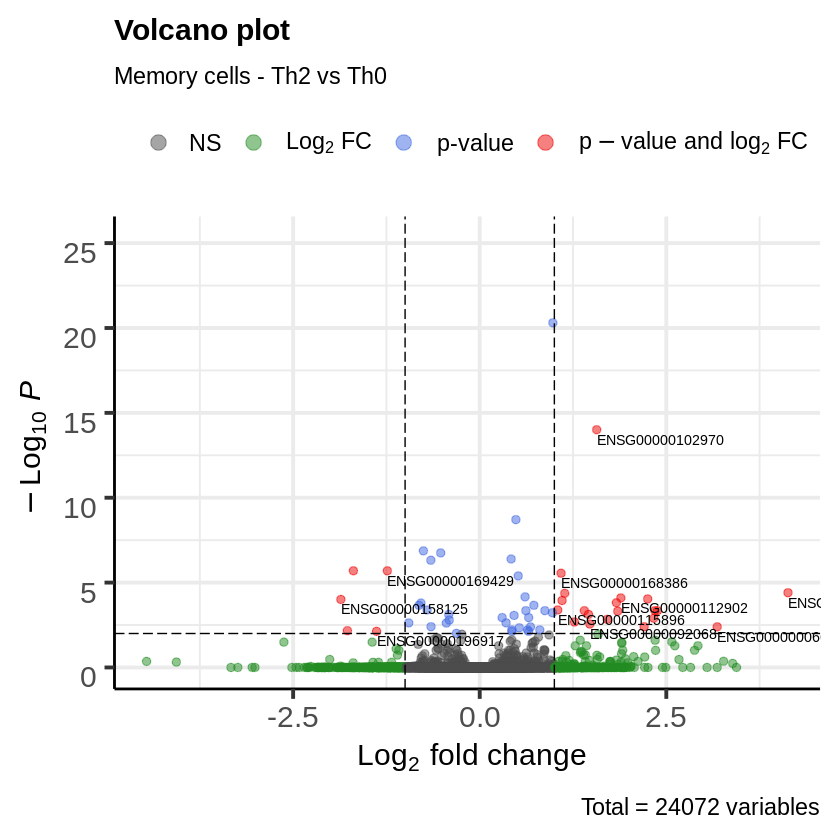

In [35]:
# Finally, a volcano plot is a good way of visualizing the result of the differential expression analysis,
# including the log-fold-change and P-value of the considered genes.

EnhancedVolcano(DESeqMemRes, 
                lab = rownames(DESeqMemRes), 
                x = 'log2FoldChange', y = 'padj', 
                subtitle = 'Memory cells - Th2 vs Th0', 
                labSize = 3, 
                pCutoff = 0.01,
                FCcutoff = 1,
                drawConnectors = FALSE)

## Compare lists of DEGs to find shared and unique genes between naive and memory CD4+ cells

In [36]:
# Now we can make two lists of DEGs for naive and memory cells, wbich we can then compare.
# Apply the same two criteria to create an index, column padj <= 0.01 and the 
# absolute value of column log2FoldChange > 1, to both DESeq2 result tables.
# Finally, store the shared DEGs between cell types in the list "sharedDEGs",
# "naiveSpecificDEGs" and "memSpecificDEGs". Hint: the functions "intersect" and "setdiff" come in handy here
# Apply the same criteria to create indices for naive and memory cell DEGs
naive_idx <- which(DESeqResSorted$padj <= 0.01 & abs(DESeqResSorted$log2FoldChange) > 1)
mem_idx <- which(DESeqMemResSorted$padj <= 0.01 & abs(DESeqMemResSorted$log2FoldChange) > 1)

# Get the gene names for each index
naiveDEGs <- rownames(DESeqResSorted)[naive_idx]
memDEGs <- rownames(DESeqMemResSorted)[mem_idx]

# Find shared DEGs and specific DEGs
sharedDEGs <- intersect(naiveDEGs, memDEGs)
naiveSpecificDEGs <- setdiff(naiveDEGs, memDEGs)
memSpecificDEGs <- setdiff(memDEGs, naiveDEGs)
#sharedDEGs <- ...
#naiveSpecificDEGs <- ...
#memSpecificDEGs <- ...

# your code here


# And our 10 genes with the stronges response are:
cat("Number of shared DEGs between memory and naive CD4+ cells:" , length(sharedDEGs), "\n")
cat("Number of DEGs specific to naive CD4+ cells:" , length(naiveSpecificDEGs), "\n")
cat("Number of DEGs specific to memory CD4+ cells:" , length(memSpecificDEGs), "\n")

Number of shared DEGs between memory and naive CD4+ cells: 21 
Number of DEGs specific to naive CD4+ cells: 918 
Number of DEGs specific to memory CD4+ cells: 4 
